# 2] Données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utility import Utility
from sklearn.metrics import confusion_matrix, accuracy_score  # utilise lors d'evaluation
import matplotlib.pyplot as plt
import seaborn as sn 
import math



train_data = pd.read_csv('raw_train.csv')
test_data = pd.read_csv('raw_test.csv')

# Question 5

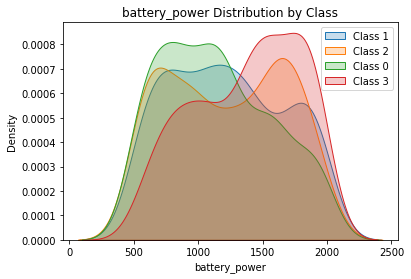

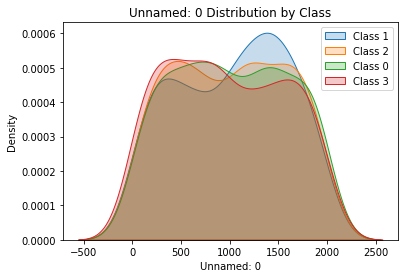

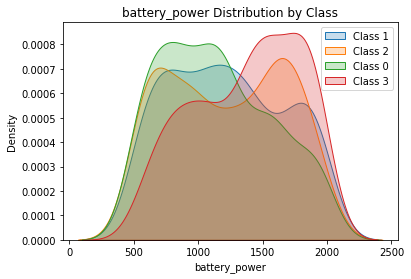

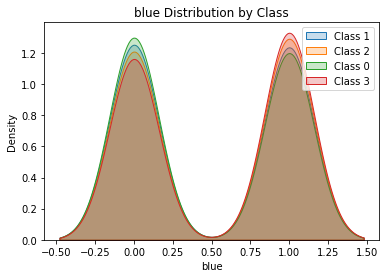

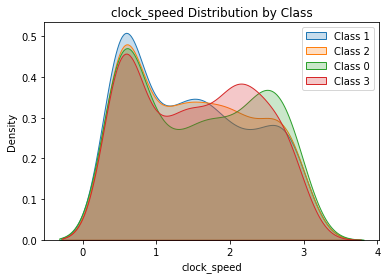

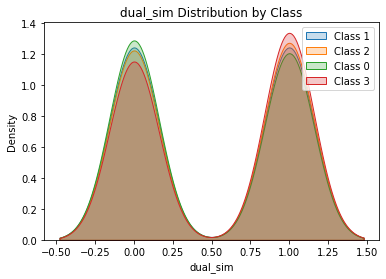

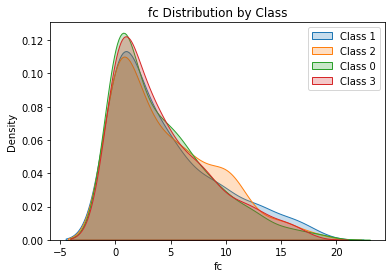

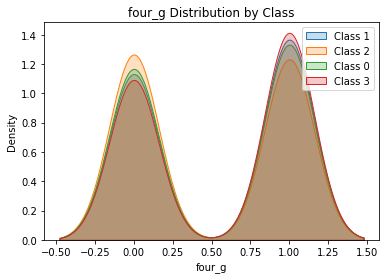

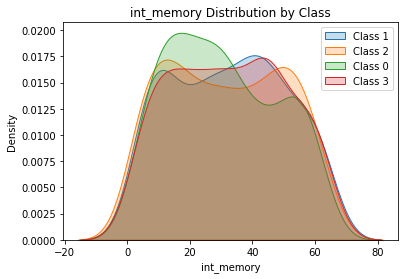

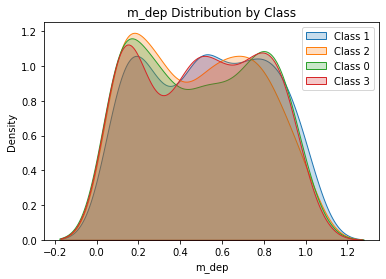

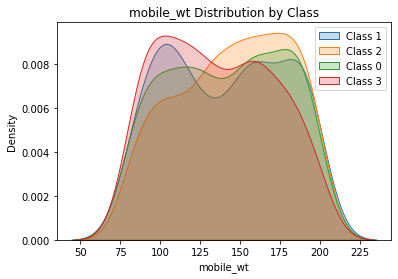

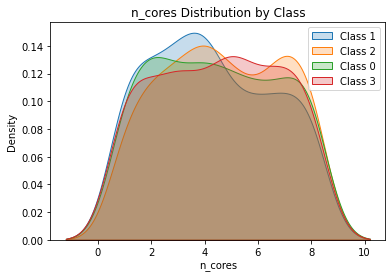

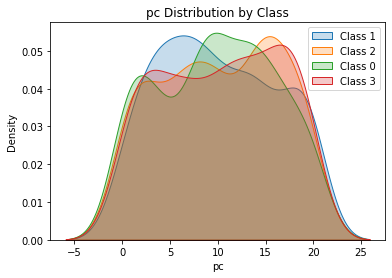

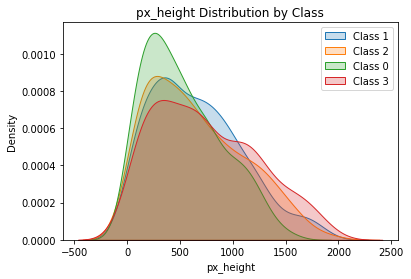

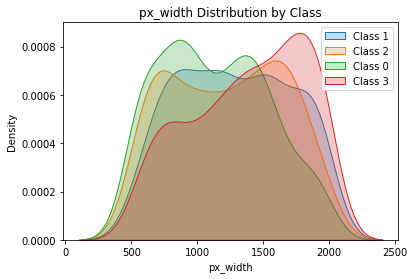

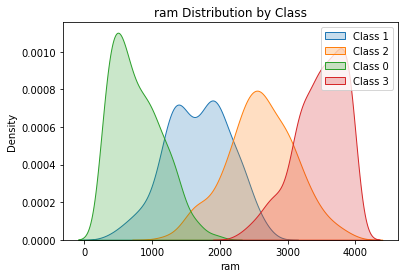

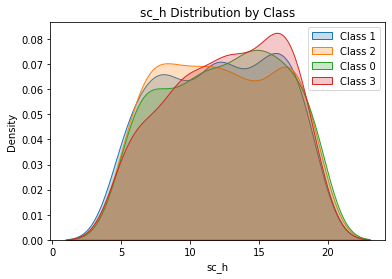

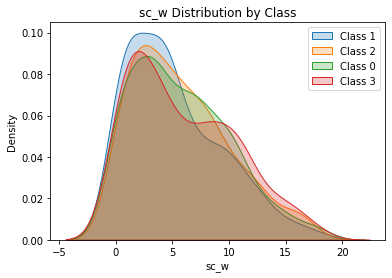

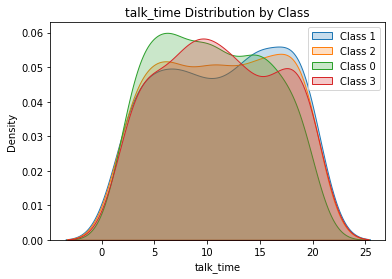

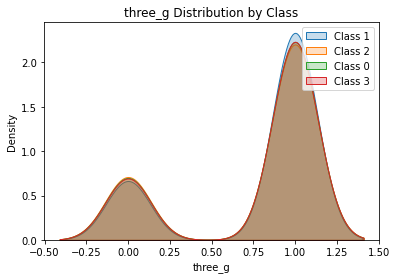

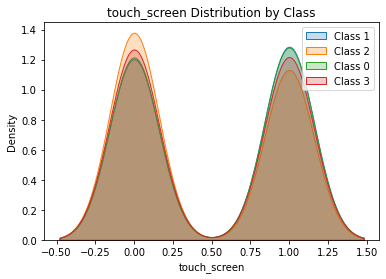

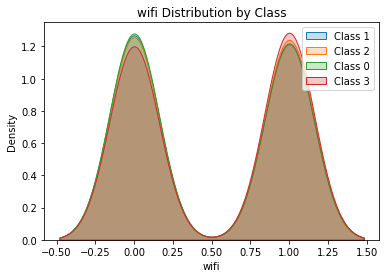

In [2]:
def plot_kdeplots(data, feature, class_col):
    classes = data[class_col].unique()
    
    for cls in classes:
        sn.kdeplot(data[data[class_col] == cls][feature], label=f'Class {cls}', fill=True)
    
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title(f'{feature} Distribution by Class')
    plt.legend()
    plt.show()

# Exemple d'utilisation de la fonction pour l'attribut "battery_power"
plot_kdeplots(train_data, 'battery_power', 'price_range')
# Liste des colonnes de caractéristiques (exclure la colonne de classe "price_range")
feature_columns = [col for col in train_data.columns if col != 'price_range']

# Afficher les distributions pour chaque attribut
for feature in feature_columns:
    plot_kdeplots(train_data, feature, 'price_range')


# Question 7

In [3]:
def normalize_data(df):
    # Convertir le dataframe en Numpy
    data = df.to_numpy()

    # Calcul le minimum et le maximum de chaque attribut
    min_values = np.min(data, axis=0)
    max_values = np.max(data, axis=0)
    ranges = max_values - min_values
    # Eviter la  division par  zero
    ranges[ranges == 0] = 1
    data_normalized = -1 + 2 * (data - min_values) / ranges
    df_normalized = pd.DataFrame(data_normalized, columns=df.columns, index=df.index)

    return df_normalized

In [4]:
                ##############  Nettoyage et Normalisation  des Donnees ###########

# Convertir les données en DataFrames pandas
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

# Supprimer la première colonne (index) à la fois dans train_data et test_data
train_data.drop(columns=['Unnamed: 0'], inplace=True)
test_data.drop(columns=['Unnamed: 0'], inplace=True)

# Séparer les caractéristiques et les étiquettes
train_features = train_data.drop(columns=['price_range'])
train_labels = train_data['price_range']

test_features = test_data.drop(columns=['price_range'])
test_labels = test_data['price_range']

normalized_train_features = normalize_data(train_features)
normalized_test_features = normalize_data(test_features)


# 4.1] Apprentissage de l’auto-encodeur

# Question 5

In [5]:
class AutoEncoder:
    
    def __init__(self, input_dim, latent_dim):
        self.W1, self.b1, self.W2, self.b2 = self.init_weights(input_dim, latent_dim)
        self.train_costs = []  # Liste pour enregistrer les coûts d'entraînement
        self.test_costs = []  # Liste pour enregistrer les coûts de test
        self.costs = []

    def init_weights(self, input_dim, latent_dim):
        W1 = np.random.uniform(-1, 1, size=(latent_dim, input_dim))
        b1 = np.zeros((latent_dim, 1))
        W2 = np.random.uniform(-1, 1, size=(input_dim, latent_dim))
        b2 = np.zeros((input_dim, 1))

        return W1, b1, W2, b2


    # Méthode pour le propogation en avant
    def forward_pass(self, X):
        Z1 = np.dot(self.W1, X) + self.b1
        A1 = np.tanh(Z1)
        Z2 = np.dot(self.W2, A1) + self.b2
        A2 = np.tanh(Z2)
        return A1, A2

    # Méthode pour le backpropogation
    def backward_pass(self, X, A1, A2, learning_rate):
        
        # Obtenir la dimension d'entrée
        d = X.shape[0]

        # Calcule les gradients pour la dernière couche
        dZ2 = (2/d) * (A2 - X) * (1 - np.square(A2)) # Modifier la formule de rétro-propagation du gradient au sein de la der-nière couche
        dW2 = np.dot(dZ2, A1.T)
        # Convertir DataFrame en tableau numpy 
        if isinstance(dZ2, pd.DataFrame):
            dZ2 = dZ2.to_numpy()
        db2 = np.sum(dZ2, axis=1, keepdims=True)
        dZ1 = np.dot(self.W2.T, dZ2) * (1 - np.square(A1))
        dW1 = np.dot(dZ1, X.T)
        # Convertir DataFrame en tableau numpy 
        if isinstance(dZ1, pd.DataFrame):
            dZ1 = dZ1.to_numpy()
        db1 = np.sum(dZ1, axis=1, keepdims=True)

        # Mettre à jour les poids et les biais
        self.W1 = self.W1 - learning_rate * dW1
        self.b1 = self.b1 - learning_rate * db1
        self.W2 = self.W2 - learning_rate * dW2
        self.b2 = self.b2 - learning_rate * db2

    # Méthode pour évaluer le modèle sur l'ensemble de test
    def evaluate(self, X_test):
        A1_test, A2_test = self.forward_pass(X_test)
        test_loss = np.mean(Utility.MSE_cost(A2_test, X_test))  # Calculer la perte moyenne
        self.test_costs.append(test_loss)  # Ajouter la perte de test à la liste

      # Méthode pour entrainer le modèle   
    def train(self, X, X_test, epochs, learning_rate):
            m = X.shape[1]
            for epoch in range(epochs):
                # Forward pass
                A1, A2 = self.forward_pass(X)
                
                loss = np.mean(Utility.MSE_cost(A2, X))  # Calculer la perte moyenne
                self.train_costs.append(loss)  # Ajouter la perte d'entraînement à la liste
                print(f'Époque : {epoch}, Perte : {loss:.3f}')

                # Backward pass
                self.backward_pass(X, A1, A2, learning_rate)

                # Évaluer sur l'ensemble de test
                self.evaluate(X_test)

            # Après l'entraînement, tracer les coûts d'entraînement et de test
            plt.plot(self.train_costs, label='Coût d\'entraînement')
            plt.plot(self.test_costs, label='Coût de test')
            plt.title('Coût d\'entraînement et de test au fil des époques')
            plt.xlabel('Époques')
            plt.ylabel('Coût')
            plt.legend()
            plt.show()



Époque : 0, Perte : 0.800
Époque : 1, Perte : 0.570
Époque : 2, Perte : 0.495
Époque : 3, Perte : 0.465
Époque : 4, Perte : 0.450
Époque : 5, Perte : 0.443
Époque : 6, Perte : 0.439
Époque : 7, Perte : 0.436
Époque : 8, Perte : 0.434
Époque : 9, Perte : 0.431
Époque : 10, Perte : 0.429
Époque : 11, Perte : 0.427
Époque : 12, Perte : 0.425
Époque : 13, Perte : 0.422
Époque : 14, Perte : 0.420
Époque : 15, Perte : 0.418
Époque : 16, Perte : 0.416
Époque : 17, Perte : 0.414
Époque : 18, Perte : 0.412
Époque : 19, Perte : 0.410
Époque : 20, Perte : 0.409
Époque : 21, Perte : 0.408
Époque : 22, Perte : 0.406
Époque : 23, Perte : 0.405
Époque : 24, Perte : 0.404
Époque : 25, Perte : 0.403
Époque : 26, Perte : 0.402
Époque : 27, Perte : 0.402
Époque : 28, Perte : 0.401
Époque : 29, Perte : 0.400
Époque : 30, Perte : 0.399
Époque : 31, Perte : 0.399
Époque : 32, Perte : 0.398
Époque : 33, Perte : 0.397
Époque : 34, Perte : 0.396
Époque : 35, Perte : 0.395
Époque : 36, Perte : 0.394
Époque : 37

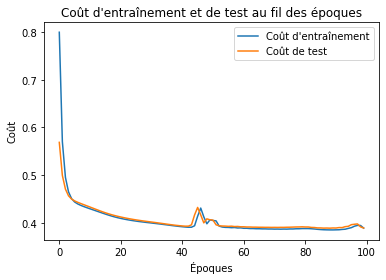

In [6]:
input_dim = train_features.shape[1]
latent_dim = 2
autoencoder = AutoEncoder(input_dim, latent_dim)

# Entraîner l'autoencodeur avec les données d'entraînement normalisées
autoencoder.train(normalized_train_features.T, normalized_test_features.T, epochs=100, learning_rate=0.01)

# 4.2] Apprentissage de l’arbre de décision dans l’espace latent

# Question 2

In [7]:
class Node:
    def __init__(self, attribute=None, split_value=None, left_branch=None, right_branch=None, prediction=None, isLeaf=False):
        self.attribute = attribute
        self.split_value = split_value
        self.left_branch = left_branch
        self.right_branch = right_branch
        self.prediction = prediction
        self.isLeaf = isLeaf

def entropie(dataframe, cible):
    nb_lignes = dataframe.shape[0]
    series = dataframe[cible].value_counts()
    entropie = 0
    for classe, count in series.items():
        proportion = count / nb_lignes
        entropie -= proportion * (0 if proportion == 0 else math.log2(proportion))
    return entropie

def meilleur_attribut(data, cible, attributs_restants):
    max_gain = 0
    meilleur_attribut = None
    split_value = None
    meilleures_partitions = []

    for attribut in attributs_restants:
        data_sorted = data.sort_values(by=attribut)
        gain, split, partitions = calcul_gain(data_sorted, attribut, cible)
        if gain > max_gain:
            max_gain = gain
            meilleur_attribut = attribut
            split_value = split
            meilleures_partitions = partitions

    return meilleur_attribut, max_gain, split_value, meilleures_partitions


def calcul_gain(data, attribut, cible):
    E = entropie(data, cible)
    gain = 0
    split_value = 0
    partitions = []
    sorted_data = data.sort_values(by=attribut)
    current_class = sorted_data[cible].iloc[0]

    for i, instance in sorted_data.iterrows():
        if instance[cible] != current_class:
            split_value = instance[attribut]
            partitions = [data[data[attribut] < split_value], data[data[attribut] >= split_value]]
            # Assurer que les partion ne sont pas vides
            if len(partitions[0]) > 0 and len(partitions[1]) > 0:
                gain = E - (entropie(partitions[0], cible) * len(partitions[0]) + entropie(partitions[1], cible) * len(partitions[1])) / len(data)
                break

    return gain, split_value, partitions


def construction_arbre(data, cible, attributs_restants, profondeur, seuil=3):
    attribut, gain, split, partitions = meilleur_attribut(data, cible, attributs_restants)
    prediction = data[cible].value_counts()

    if profondeur > seuil or not attributs_restants or not partitions:
        return Node(prediction=prediction, isLeaf=True)

    if attribut in attributs_restants:
        attributs_restants.remove(attribut)
    branche_gauche = construction_arbre(partitions[0], cible, attributs_restants.copy(), profondeur+1)
    branche_droite = construction_arbre(partitions[1], cible, attributs_restants.copy(), profondeur+1)

    return Node(attribut, split, branche_gauche, branche_droite, prediction)


def print_tree(node, spacing=''):
    if node is None:
        return
    if node.isLeaf:
        print(spacing + str(node.prediction))
        return
    print('{}[Attribute: {} Split value: {}]'.format(spacing, node.attribute, node.split_value))
    print(spacing + '> True')
    print_tree(node.left_branch, spacing + '-')
    print(spacing + '> False')
    print_tree(node.right_branch, spacing + '-')

def predict(node, instance):
    if node.isLeaf:
        return node.prediction.idxmax()
    if instance[node.attribute] < node.split_value:
        return predict(node.left_branch, instance)
    else:
        return predict(node.right_branch, instance)

In [8]:
# la fonction fθ1 (xi) pour tout élément xi des deux jeux de données.
def encode(W1, b1, X):
    Z1 = W1.dot(X) + b1
    A1 = np.tanh(Z1)
    return A1

W1 = autoencoder.W1
b1 = autoencoder.b1

# Encoder les données train et de test
encoded_train_data_np = encode(W1, b1, normalized_train_features.T)
encoded_test_data_np = encode(W1, b1, normalized_test_features.T)

# On fait la transpostion pour respecter la dimensionalite
encoded_train_data_np = encoded_train_data_np.T
encoded_test_data_np = encoded_test_data_np.T

# Convertir les tableaux numpy en DataFrames pandas
encoded_train_data = pd.DataFrame(encoded_train_data_np, columns=[f'Feature{i}' for i in range(1, latent_dim+1)])
encoded_test_data = pd.DataFrame(encoded_test_data_np, columns=[f'Feature{i}' for i in range(1, latent_dim+1)])

# Ajouter les étiquettes (classe) aux données
encoded_train_data['price_range'] = train_labels.reset_index(drop=True)
encoded_test_data['price_range'] = test_labels.reset_index(drop=True)

# Construire l'arbre de décision en utilisant les données d'entraînement encodées dans l'espace latent d' = 2
attributs_restants = ['Feature1', 'Feature2']
arbre = construction_arbre(encoded_train_data, 'price_range', attributs_restants, profondeur=0)


# Question 4] Evaluation (on a utilise L’exactitude pondérée EP (weighted accuracy)Le    taux de bonne classification pour chaque classe i, noté Ti)

In [9]:
def predict_example(tree, example):
    return predict(tree, example)

def evaluate_tree(tree, X_test, y_test):
    # Prédire les classes pour l'ensemble de test
    y_pred = [predict_example(tree, x) for x in X_test.to_dict(orient='records')]

    # Calculer la matrice de confusion
    confusion_mat = confusion_matrix(y_test, y_pred)

    # Calculer l'exactitude pondérée (EP)
    accuracy_weighted = accuracy_score(y_test, y_pred)

    # Calculer le taux de bonne classification pour chaque classe (Ti)
    correct_classifications = np.diag(confusion_mat)
    total_classifications = np.sum(confusion_mat, axis=1)
    correct_classification_rate = correct_classifications / total_classifications

    print(f'Exactitude pondérée (EP): {accuracy_weighted}')
    for i, rate in enumerate(correct_classification_rate):
        print(f'Taux de bonne classification pour la classe {i} (T{i}): {rate}')
evaluate_tree(arbre, encoded_test_data.drop('price_range', axis=1), encoded_test_data['price_range'])


Exactitude pondérée (EP): 0.245
Taux de bonne classification pour la classe 0 (T0): 0.0
Taux de bonne classification pour la classe 1 (T1): 0.0
Taux de bonne classification pour la classe 2 (T2): 1.0
Taux de bonne classification pour la classe 3 (T3): 0.0
